**Part 3. AI Agent 심화 프로젝트**

- Chapter 03. GraphRAG

    - **📒[실습]** Clip 07. Vector + Graph RAG 구현하기🗒️

## 🔗 Graph DB 연결하기

영화 추천 데이터셋 : https://github.com/neo4j-graph-examples/recommendations

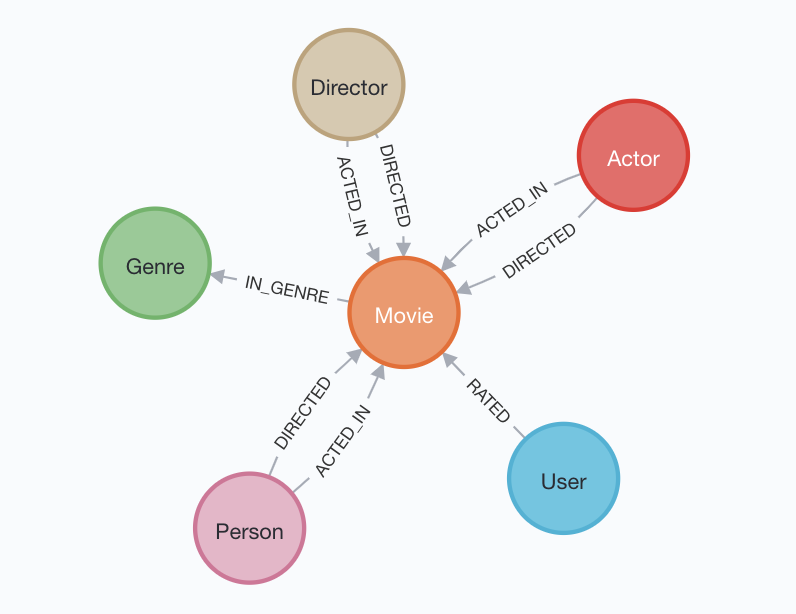

1) Aura DB

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j+s://d5b08997.databases.neo4j.io"
AUTH = ("neo4j", "p_rgueTfG5wvMOnIuVej1hTXA6LQP3b9uqz3LHdUbV0")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

2) Sandbox : https://github.com/neo4j-graph-examples/recommendations

In [1]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j://44.197.170.109:7687"
AUTH = ("neo4j", "nineties-breaks-preservers")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [2]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [4]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

## 🧑‍💻 Vector + Graph 기반 RAG 구현하기

### 1️⃣ Embedding, Vector INDEX 추가하기

In [6]:
from neo4j_graphrag.embeddings.sentence_transformers import SentenceTransformerEmbeddings

embedder = SentenceTransformerEmbeddings(
    model="all-MiniLM-L6-v2",
)

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with driver.session() as session:
    result = session.run("MATCH (m:Movie) WHERE m.plot IS NOT NULL RETURN elementId(m) AS id, m.plot AS plot")
    records = result.data()

    for record in records:
        node_id = record["id"]
        text = record["plot"]
        vector = embedder.embed_query(text)

        session.run("""
        MATCH (m) WHERE elementId(m) = $id
        SET m.embedding = $embedding
        """, {"id": node_id, "embedding": vector})

In [9]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "plotindex"
DIMENSION=384

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Movie",
        embedding_property="embedding",
        dimensions=DIMENSION,
        similarity_fn="cosine",
    )

### 2️⃣ VectorCypher Retriever 사용하기

> `VectorCypherRetriever`
> - driver (neo4j.Driver) – Neo4j 파이썬 드라이버
> - index_name (str) – Vector INDEX 이름
> - retrieval_query (str) – 추가 그래프 순회를 위한 쿼리
> - embedder (Optional[Embedder]) – 임베딩 모델

- 영화(node)에 출연한 배우(Actor) 정보

In [7]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

INDEX_NAME = "plotindex"

retrieval_query = """
MATCH
(actor:Actor)-[:ACTED_IN]->(node)
RETURN
node.title AS movie_title,
node.plot AS movie_plot, 
collect(actor.name) AS actors;
"""
retriever = VectorCypherRetriever(
    driver,
    index_name=INDEX_NAME,
    retrieval_query=retrieval_query,
    embedder= embedder
)

In [8]:
retriever.search(query_text="Who were the actors in the movie about the magic jungle board game?", top_k=5)

RetrieverResult(items=[RetrieverResultItem(content="<Record movie_title='Jumanji' movie_plot='When two kids find and play a magical board game, they release a man trapped for decades in it and a host of dangers that can only be stopped by finishing the game.' actors=['Robin Williams', 'Bradley Pierce', 'Kirsten Dunst', 'Jonathan Hyde']>", metadata=None), RetrieverResultItem(content="<Record movie_title='¡Three Amigos!' movie_plot='Three actors accept an invitation to a Mexican village to perform their onscreen bandit fighter roles, unaware that it is the real thing.' actors=['Steve Martin', 'Martin Short', 'Chevy Chase', 'Alfonso Arau']>", metadata=None), RetrieverResultItem(content="<Record movie_title='Lola Montès' movie_plot='The film tells the tragic story of Lola Montès, a great adventurer who becomes the main attraction of a circus after being the lover of various important European men.' actors=['Anton Walbrook', 'Peter Ustinov', 'Martine Carol', 'Henri Guisol']>", metadata=None

- 영화(node)에 대한 장르(Genre), 배우(Actor) 등 정보

In [9]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

INDEX_NAME = "plotindex"

retrieval_query = """
MATCH 
(actor:Actor)-[:ACTED_IN]->(node)-[:IN_GENRE]->(genre:Genre)
RETURN 
node.title AS movie_title,
node.plot AS movie_plot,
collect(DISTINCT actor.name) AS actors,
collect(DISTINCT genre.name) AS genres;
"""
retriever = VectorCypherRetriever(
    driver,
    index_name=INDEX_NAME,
    retrieval_query=retrieval_query,
    embedder= embedder
)

In [10]:
retriever.search(query_text="What is the movie about the magic board game?", top_k=5)

RetrieverResult(items=[RetrieverResultItem(content="<Record movie_title='Jumanji' movie_plot='When two kids find and play a magical board game, they release a man trapped for decades in it and a host of dangers that can only be stopped by finishing the game.' actors=['Robin Williams', 'Bradley Pierce', 'Kirsten Dunst', 'Jonathan Hyde'] genres=['Adventure', 'Children', 'Fantasy']>", metadata=None), RetrieverResultItem(content='<Record movie_title=\'Bloodsucking Freaks\' movie_plot="Sardu, master of the Theatre of the Macabre, and his assistant Ralphus run a show in which, under the guise of \'magic\', they torture and murder people in front of their audience. But what the punters see as a trick is actually real." actors=["Seamus O\'Brien", \'Viju Krem\', \'Niles McMaster\', \'Dan Fauci\'] genres=[\'Horror\']>', metadata=None), RetrieverResultItem(content="<Record movie_title='August Rush' movie_plot='A drama with fairy tale elements, where an orphaned musical prodigy uses his gift as a 

### 3️⃣ GraphRAG 파이프라인 모듈 사용하기

In [11]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import RagTemplate, GraphRAG

prompt_template = RagTemplate(
    template="""
        You are a helpful movie assistant. Based on the provided plot-based question and retrieved movie information, identify the most relevant movie and explain it to the user in a clear and concise manner.

        Use the context to include:
        - the movie title
        - a brief plot summary (if available)
        - genre(s)
        - main actor(s)

        If multiple movies match, mention the most likely one and briefly list alternatives.

        Answer the question below naturally and informatively in Korean.

        Question: {query_text}

        Context: {context}

        Answer: """,
    expected_inputs=["context", "query_text"]
)


llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm, prompt_template=prompt_template)

In [12]:
query = "What is the movie about the magic board game?"
response = graph_rag.search(query_text=query, return_context = True)

In [13]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)

## 생성 답변 ##
"주만지"라는 영화가 마법 보드 게임에 관한 영화입니다. 이 영화는 두 아이가 마법의 보드 게임을 찾고 플레이하면서 벌어지는 이야기를 다룹니다. 게임을 하다 보니 수십 년 동안 게임 속에 갇혀 있던 남자가 풀려나고, 게임을 끝내야만 멈출 수 있는 다양한 위험들이 발생하게 됩니다. 

장르는 모험, 어린이, 판타지이고, 주요 배우로는 로빈 윌리엄스, 브래들리 피어스, 커스틴 던스트, 조나단 하이드가 출연합니다. 

이 영화 외에는 마법과 관련된 내용의 영화가 있지만 "주만지"가 가장 해당 주제에 잘 맞는 영화입니다.

## 검색 결과 ##
<Record movie_title='Jumanji' movie_plot='When two kids find and play a magical board game, they release a man trapped for decades in it and a host of dangers that can only be stopped by finishing the game.' actors=['Robin Williams', 'Bradley Pierce', 'Kirsten Dunst', 'Jonathan Hyde'] genres=['Adventure', 'Children', 'Fantasy']>
<Record movie_title='Bloodsucking Freaks' movie_plot="Sardu, master of the Theatre of the Macabre, and his assistant Ralphus run a show in which, under the guise of 'magic', they torture and murder people in front of their audience. But what the punters see as a trick is actually real." actors=["Seamus O'Brien", 'Viju Krem', 'Niles McMaster', 'Dan Fau

In [14]:
query = "A cowboy doll and new spaceman figure in a boy's room?"
response = graph_rag.search(query_text=query, return_context = True)

In [15]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)

## 생성 답변 ##
그 영화는 '토이 스토리'입니다. 

- **영화 제목**: 토이 스토리
- **줄거리**: 카우보이 인형이 새로운 우주비행사 피규어가 어린 소년의 방에서 최고 장난감 자리를 빼앗자 깊은 위협을 느끼고 질투하게 됩니다.
- **장르**: 모험, 애니메이션, 어린이, 코미디, 판타지
- **주연 배우**: 짐 바니, 팀 알렌, 톰 행크스, 돈 리클스

소년의 방에 있는 카우보이 인형과 새로 온 우주비행사 인형에 대한 내용이 이 영화의 주요 테마입니다.

## 검색 결과 ##
<Record movie_title='Toy Story' movie_plot="A cowboy doll is profoundly threatened and jealous when a new spaceman figure supplants him as top toy in a boy's room." actors=['Jim Varney', 'Tim Allen', 'Tom Hanks', 'Don Rickles'] genres=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']>
<Record movie_title="Bride of Chucky (Child's Play 4)" movie_plot='Chucky, the doll possessed by a serial killer, discovers the perfect mate to kill and revive into the body of another doll.' actors=['Jennifer Tilly', 'Nick Stabile', 'Katherine Heigl', 'Brad Dourif'] genres=['Horror', 'Thriller', 'Comedy']>
<Record movie_title='Secret Adventures of Tom Thumb, The' movie_plot='A boy born the size of a small doll is kidnapp